## Dataset

In [1]:
import os.path

In [2]:
OUT_DIR = '/content/clouderizer/semantic-seg/out'
DATA_DIR = '/content/clouderizer/semantic-seg/data'

In [3]:
CUR_DIR = os.getcwd()

print(os.listdir(CUR_DIR))
print(os.listdir(OUT_DIR))
print(os.listdir(DATA_DIR))

['sms.py', 'project_tests.py', '.helper.py.swp', 'inference_seg.py', 'tf-save-load.ipynb', 'my_utils.py', 'helper.py', 'run.ipynb', 'semantic-segmentation-data-preprocessing.ipynb', 'tf_print.py', '__pycache__', 'semantic-segmentation-prediction.ipynb', 'main.py', 'eval.py', 'inference_run_single.py', 'convert_ckpt_to_graph.py', 'tf-print-architecture.ipynb', 'optimise.sh', '.ipynb_checkpoints', 'inference_run_multi.py', 'data']
['model1', 'out.txt']
['Train', 'val', 'Train2', 'carla-capture-20180528.zip', 'lyft_training_data.tar.gz']


In [4]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 1.9MB/s ta 0:00:01


In [9]:
os.chdir(DATA_DIR)

In [13]:
!ls

carla-capture-20180528.zip  lyft_training_data.tar.gz  Train  Train2


In [ ]:
!tar -xvf lyft_training_data.tar.gz

In [ ]:
!unzip carla-capture-20180528.zip -d Train2

In [14]:
!mkdir val

In [15]:
os.chdir(DATA_DIR+'/val')

In [16]:
!mkdir CameraRGB
!mkdir CameraSeg

In [17]:
os.chdir(CUR_DIR)

In [5]:
from glob import glob
import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil

%matplotlib inline

### Train Data

In [6]:
image_paths = glob(os.path.join(DATA_DIR, 'Train/CameraRGB', '*.png'))
label_paths = glob(os.path.join(DATA_DIR, 'Train/CameraSeg', '*.png'))
print("Total training images: ",len(image_paths))
print("Total training lables: ",len(label_paths))

Total training images:  1000
Total training lables:  1000


Train image shape:  (600, 800, 3)
Label image shape:  (600, 800, 3)


Text(0.5,1,'Label')

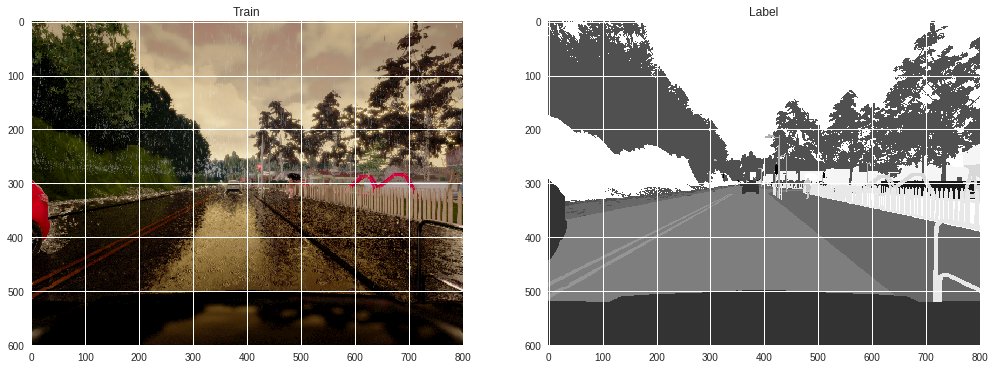

In [19]:
img_path = image_paths[0]
label_path = label_paths[0]
train_img = scipy.misc.imread(img_path)
label_img = scipy.misc.imread(label_path)

print("Train image shape: ", train_img.shape)
print("Label image shape: ", label_img.shape)

fig = plt.figure(figsize=(17,15))
plt.subplot(121)
plt.imshow(train_img)
plt.title('Train')
plt.subplot(122)
plt.imshow(label_img[:,:,0]) # Only channel 0- [RED] has classification info
plt.title('Label')

### Validation data

In [20]:
# 200 images as Validation
image_paths = glob(os.path.join(DATA_DIR, 'Train2/CameraRGB', '*.png'))
label_paths = glob(os.path.join(DATA_DIR, 'Train2/CameraSeg', '*.png'))
print("Total training images: ",len(image_paths))
print("Total training lables: ",len(label_paths))

Total training images:  1000
Total training lables:  1000


In [21]:
mv_dir = DATA_DIR + '/val/CameraRGB'
mv_dir_seg = DATA_DIR + '/val/CameraSeg'
rand_idxes = random.sample(range(1000),200)
for i in rand_idxes:
    shutil.move(image_paths[i], mv_dir)
    shutil.move(label_paths[i], mv_dir_seg)

In [7]:
image_paths = glob(os.path.join(DATA_DIR, 'val/CameraRGB', '*.png'))
label_paths = glob(os.path.join(DATA_DIR, 'val/CameraSeg', '*.png'))
print("Total training images: ",len(image_paths))
print("Total training lables: ",len(label_paths))

Total training images:  200
Total training lables:  200


## Model

In [8]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
from my_utils import session_config, save_model, create_predictions
from eval import eval_nn, weighted_loss
import numpy as np
import sys
#from sms import send_sms
#import csv

In [9]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0-rc1
Default GPU Device: /device:GPU:0


In [10]:
#######--HYPER PARAMETERS--############################
EPOCHS = 40 #20 #10
BATCH_SIZE = 32 #32 16 8

NUM_CLASSES = 3  # car,road,others
IMAGE_SHAPE = (96, 160) #(480, 800)  (352, 800) (96, 128) (480, 800) (160, 576)

# Work Directory Settings
#DATA_DIR = './data'
#RUNS_DIR = './runs'
CKPT_DIR = OUT_DIR + '/model1/model1'
SAVE_DIR = OUT_DIR + '/model1/savedmodel'

LOSS_WEIGHT = np.array([0.57,0.28,0.15]) # class 0:car, 1:road, 2: none
#LOSS_WEIGHT = np.array([0.55,0.30,0.15]) # class 0:car, 1:road, 2: none
#LOSS_WEIGHT = np.array([0.50,0.25,0.25]) # class 0:car, 1:road, 2: none

In [12]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    #  Use tf.saved_model.loader.load to load the model and weights
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    # get the graph first
    graph = tf.get_default_graph()
    # load followings into the graph by names
    image_input = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3_out = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4_out = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7_out = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return image_input, keep_prob, layer3_out, layer4_out, layer7_out
    
tests.test_load_vgg(load_vgg, tf)


def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify  - pixel is road OR not road
    :return: The Tensor for the last layer of output
    """
    # Outputs of pooling layers 3 and 4 are scaled before they are fed into the 1x1 convolutions.
    vgg_layer3_out = tf.multiply(vgg_layer3_out, 0.0001)
    vgg_layer4_out = tf.multiply(vgg_layer4_out, 0.01)
    
    regularizer = tf.contrib.layers.l2_regularizer(1e-3)    
    ####### Layer7,4,3 - 1x1 Convolution  #####################
    # Add L2 Regularizer to prevent overfitting to each layer
    layer7_conv_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes,
            kernel_size=1, strides=(1,1), padding='same', \
            kernel_regularizer = regularizer )
    #layer7_conv_1x1 = tf.Print(layer7_conv_1x1, [tf.shape(layer7_conv_1x1)], ">>>>>L7 Conv1x1:", first_n=2, summarize=4)
    
    layer4_conv_1x1 = tf.layers.conv2d(vgg_layer4_out, num_classes, \
            kernel_size=1, strides=(1,1), padding='same', \
            kernel_regularizer = regularizer )
    
    layer3_conv_1x1 = tf.layers.conv2d(vgg_layer3_out, num_classes, \
            kernel_size=1, strides=(1,1), padding='same', \
            kernel_regularizer = regularizer )

    
    ####### Layer7,4,3 1x1 Conv - Upsample & Skip ############
    output = tf.layers.conv2d_transpose(layer7_conv_1x1, num_classes, \
            kernel_size=4, strides=(2,2), padding='same', \
            kernel_regularizer = regularizer )    
    output = tf.add(output, layer4_conv_1x1)
    
    output = tf.layers.conv2d_transpose(output, num_classes, \
            kernel_size=4, strides = (2,2), padding='same', \
            kernel_regularizer = regularizer )
    output = tf.add(output, layer3_conv_1x1)

    output = tf.layers.conv2d_transpose(output, num_classes, \
            kernel_size=16, strides = (8,8), padding='same', \
            kernel_regularizer = regularizer )


    return output

tests.test_layers(layers)


def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    ### Reshape 4D tensor to 2D tensor
    logits = tf.reshape(nn_last_layer, (-1, num_classes), name='logits_2d')
    ### Reshape 4D tensor to 2D tensor
    labels = tf.reshape(correct_label, (-1, num_classes), name='labels_2d')
    ### use Cross Entropy Loss
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels= labels), name = 'loss')
    
    '''
    When adding l2-regularization, setting a regularizer in the arguments of 
    the tf.layers is not enough. Regularization loss terms must be manually 
    added to your loss function. otherwise regularization is not implemented.
    '''
    regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    cross_entropy_loss = tf.add(cross_entropy_loss, sum(regularization_losses))
    
    #labels = tf.argmax(labels, axis=1)
    #loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels), name = 'loss')    
    #loss = weighted_loss(logits, labels, num_classes, head=LOSS_WEIGHT)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cross_entropy_loss)    

    return logits, train_op, cross_entropy_loss

tests.test_optimize(optimize)


def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate, logits, image_shape, val_get_batches_fn, ckpt_dir):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    
    saver = tf.train.Saver()
    
    loss = 10000.0
    for epoch in range(epochs):
        for images, labels in get_batches_fn(batch_size):
            _, loss = sess.run([train_op, cross_entropy_loss], 
                feed_dict = { input_image: images, correct_label: labels, keep_prob: 0.5, learning_rate: 1e-4 })  
        
        f_car,f_road,f,val_loss = eval_nn(sess, batch_size, val_get_batches_fn, \
                    logits, cross_entropy_loss, input_image, keep_prob, image_shape,correct_label)

        print("EPOCH: {}".format(epoch + 1), " / {}".format(epochs), " Loss: {:.3f}".format(loss), \
              " F_Car: {:.3f}".format(f_car), " F_Road: {:.3f}".format(f_road)," F_: {:.3f}".format(f)," V_Loss: {:.3f}".format(val_loss) ) 
        
        if (epoch+1)%10==0:
            # TF save the graph and checkpoint
            saver.save(sess, ckpt_dir )
            print("Finish saving the epoch-{} CKPT model!".format(epoch+1))    
    
#tests.test_train_nn(train_nn)

def run():   

    #tests.test_for_kitti_dataset(DATA_DIR)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(DATA_DIR)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/

    config = session_config()

    with tf.Session(config=config) as sess:
        # Path to vgg model
        vgg_path = os.path.join(DATA_DIR, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function2(os.path.join(DATA_DIR, 'Train'))
        # for validation
        val_get_batches_fn = helper.val_gen_batch_function(os.path.join(DATA_DIR, 'val'))
        

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # TODO: Build NN using load_vgg, layers, and optimize function

        ####### Load VGG ######################    
        image_input, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)
        ####### Build FCN Layers ##############
        nn_last_layer = layers(layer3_out, layer4_out, layer7_out, NUM_CLASSES)

        # define placehoder for labels
        labels = tf.placeholder(tf.int32, [None, None, None, NUM_CLASSES], name='labels')
        # define placehoder for learning_rate
        learning_rate = tf.placeholder(tf.float32, name ='learning_rate')

        ####### Cost & Optimization ###########
        logits, train_op, cross_entropy_loss = optimize(nn_last_layer, labels, learning_rate, NUM_CLASSES)
        
        pred_softmax,pred_class = create_predictions(logits)


        # initialize variables      
        sess.run(tf.global_variables_initializer())

        # TF saver object
        #saver = tf.train.Saver()

        # TODO: Train NN using the train_nn function
        #train_nn(sess, EPOCHS, BATCH_SIZE, get_batches_fn, train_op, cross_entropy_loss, image_input, labels, keep_prob, learning_rate)
        train_nn(sess, EPOCHS, BATCH_SIZE, get_batches_fn, train_op, cross_entropy_loss, image_input, \
                labels, keep_prob, learning_rate, \
                logits,IMAGE_SHAPE,val_get_batches_fn, CKPT_DIR)

        # TF save the graph and checkpoint
        #saver.save(sess, CKPT_DIR )
        #print("Finish saving the CKPT model!")

        # save model
        """ save trained model using SavedModelBuilder """
        #save_model(sess, SAVE_DIR)
        #print("Finish saving the SavedModel!")

        # TODO: Save inference data using helper.save_inference_samples
        #helper.save_inference_samples(RUNS_DIR, DATA_DIR, sess, IMAGE_SHAPE, logits, keep_prob, image_input)

        # OPTIONAL: Apply the trained model to a video

Tests Passed
Tests Passed
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Tests Passed


In [13]:
run()

0.00B [00:00, ?B/s]

997MB [00:30, 32.6MB/s]                               


Extracting model...
INFO:tensorflow:Restoring parameters from /content/clouderizer/semantic-seg/data/vgg/variables/variables


INFO:tensorflow:Restoring parameters from /content/clouderizer/semantic-seg/data/vgg/variables/variables


MYPRINT predict Class: Tensor("predictions/prediction_class:0", shape=(?, 3), dtype=float32)


ValueError: Cannot feed value of shape (32, 96, 160, 2) for Tensor 'labels:0', which has shape '(?, ?, ?, 3)'